<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-MNIST" data-toc-modified-id="1-MNIST-1">1 MNIST</a></span></li><li><span><a href="#2-训练一个二分类器（binary-classifier）" data-toc-modified-id="2-训练一个二分类器（binary-classifier）-2">2 训练一个二分类器（binary classifier）</a></span></li><li><span><a href="#3-性能度量（Performance-measures）" data-toc-modified-id="3-性能度量（Performance-measures）-3">3 性能度量（Performance measures）</a></span><ul class="toc-item"><li><span><a href="#3.1-使用交叉验证测量准确率（accuracy）" data-toc-modified-id="3.1-使用交叉验证测量准确率（accuracy）-3.1">3.1 使用交叉验证测量准确率（accuracy）</a></span></li><li><span><a href="#3.2-混淆矩阵（Confusion-Matrix）" data-toc-modified-id="3.2-混淆矩阵（Confusion-Matrix）-3.2">3.2 混淆矩阵（Confusion Matrix）</a></span></li><li><span><a href="#3.3-精度（Precision），召回率（Recall）" data-toc-modified-id="3.3-精度（Precision），召回率（Recall）-3.3">3.3 精度（Precision），召回率（Recall）</a></span></li><li><span><a href="#3.4-Precision/recall-trade-off" data-toc-modified-id="3.4-Precision/recall-trade-off-3.4">3.4 Precision/recall trade-off</a></span></li><li><span><a href="#3.5-ROC-曲线（只二分类）" data-toc-modified-id="3.5-ROC-曲线（只二分类）-3.5">3.5 ROC 曲线（只二分类）</a></span></li></ul></li><li><span><a href="#4-多类分类（Multiclass-Classification）" data-toc-modified-id="4-多类分类（Multiclass-Classification）-4">4 多类分类（Multiclass Classification）</a></span></li><li><span><a href="#5-误差分析（Error-Analysis）" data-toc-modified-id="5-误差分析（Error-Analysis）-5">5 误差分析（Error Analysis）</a></span></li><li><span><a href="#6-多标签分类（Multilabel-Classification）" data-toc-modified-id="6-多标签分类（Multilabel-Classification）-6">6 多标签分类（Multilabel Classification）</a></span></li><li><span><a href="#7-多输出分类（Multioutput-Classification）" data-toc-modified-id="7-多输出分类（Multioutput-Classification）-7">7 多输出分类（Multioutput Classification）</a></span></li></ul></div>

In [1]:
# Common imports
import os
import sys
import warnings

# import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# mpl.rc('axes', labelsize=14)
# mpl.rc('xtick', labelsize=12)
# mpl.rc('ytick', labelsize=12)

np.random.seed(42)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

print('python version:', sys.version)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)

python version: 3.6.10 |Anaconda, Inc.| (default, May  8 2020, 02:54:21) 
[GCC 7.3.0]
pandas version: 1.1.4
scikit-learn version: 0.23.1


# 1 MNIST

这里使用 MNIST 数据集，包含 7000 张手写数字小图片，每张图片都表示一个数字。

MNIST 是 ML 中的 “hello world”。每当提出（come up with）一个新的分类算法，就会看看在 MNIST 数据集上的性能。

Scikit-Learn 提供了许多 helper functions 用于下载流行数据，MNIST 是其一。

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml(
    # 整数ID（data_id）或 name+version 作为数据集的唯一标识
    # 要么 name(+version) 要么 data_id，只能指定一个
    name='mnist_784',
    version=1,
    data_id=None
)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

输出是一个 **`sklearn.utils.Bunch`** 对象（与 dict 类似），包含以下内容

- `data` 包含一个 shape 为 `n_samples` x `n_features` 的数组


- `target` 是标签组成的数组（长度为 `n_samples`）

> 以上 2 项是必含的

- `DESCR` 描述数据集


- `feature_name`


- `target_name`

In [4]:
x, y = mnist['data'], mnist['target']
x.shape, y.shape

((70000, 784), (70000,))

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

数据集包含 70000 个样本，784 个特征，这是因为每张图片是 28x28 像素，每个特征表示一个像素的 intensity，从 0(白) 到 255(黑)。

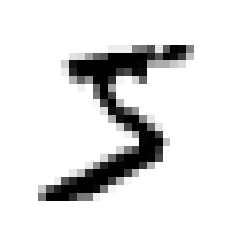

In [6]:
some_digit = x[0]
some_digit_image = some_digit.reshape((28, 28))
plt.imshow(some_digit_image, cmap=plt.cm.binary)
plt.axis('off')
plt.show()

In [7]:
# 上图对应的标签
y[0]

'5'

In [8]:
# 大部分 ML 算法希望标签是数字
y = y.astype(np.uint8)
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

在深入研究（inspect the data closely）数据集之前，应该留出测试集。

MNIST 已经将数据集切分好了——前 60000 个是训练集，剩余的 10000 个是测试集。

In [9]:
# 开始时就要留出测试集
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

In [10]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

**<font color='crimson'>打乱训练集样本顺序的好处：</font>**

- 数据集应该打乱（shuffle），这样交叉验证时每个 fold 中的数据都类似（不会某个 fold 没有某个类型的数据）。


- 有些 ML 算法对训练样本的顺序较敏感，如果连续（in a row）输入许多相似的样本，模型效果不佳。

**但是，如果数据集不是独立同分布（independently and identically distributed, iid）的话，情况可能会相反。**

# 2 训练一个二分类器（binary classifier）

先从二分类器开始吧，如预测对应的数字是不是 5 —— “5”和“非5”。

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

# True 对应 5
y_train_5

array([ True, False, False, ...,  True, False, False])

选择一个分类器并训练。一个好的初始选择是**<font color='blue' size=2>随机梯度下降（Stochastic Gradient Descent, SGD）</font>** ，使用 Scikit-Learn 的 **`SGDClassifier`**。**<font color='crimson'>`SGDClassifier` 在处理大型数据集时非常高效，部分原因是 SGD 独立地处理训练样本，一次一个（使得适合在线学习）。</font>**

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(random_state=42)

**设置 `random_state` 可以得到可复现的（reproducible）结果。**

In [13]:
sgd_clf.predict([some_digit])

array([ True])

# 3 性能度量（Performance measures）

分类的性能评估比回归要难得多（significantly trickier）。

## 3.1 使用交叉验证测量准确率（accuracy）

交叉验证（cross validation）是评估模型的一个好方法。

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

准确率 95%+。看起来很棒。

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    """A very dump classifier."""
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        # False 组成的数组
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
# 不管怎样输出都是 “非5” 的分类器
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

准确率 90%+。这是因为数据集中大约只有 10% 的图片是 5，所以预测一张图片不是 5，有 90% 的概率都是对的。

In [17]:
print("图片 5 的比例：{}%".format(y_train_5.sum() / len(y_train_5) * 100))

图片 5 的比例：9.035%


<div class="alert alert-block alert-info">
    <b>准确率（accuracy）不能作为分类器的首选性能指标，尤其是类别不均衡数据集（skewed dataset）。</b>
</div>

**可以自行实现交叉验证，可以获得跟多的控制（相较于 `cross_val_score`）。**

In [18]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

# 每个 fold 都是分层抽样产生的，各个类别的比例和总体相似
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_idx, test_idx in skfolds.split(x_train, y_train_5):
    x_train_folds = x_train[train_idx]
    y_train_folds = y_train_5[train_idx]
    x_test_fold = x_train[test_idx]
    y_test_fold = y_train_5[test_idx]

    # 每个迭代在分类器副本上训练
    clone_clf = clone(sgd_clf)
    clone_clf.fit(x_train_folds, y_train_folds)
    y_preds = clone_clf.predict(x_test_fold)
    n_correct = sum(y_preds == y_test_fold)
    print("Acc:", n_correct / len(y_preds))

Acc: 0.9669
Acc: 0.91625
Acc: 0.96785


## 3.2 混淆矩阵（Confusion Matrix）

评估分类器的更好方法是查看 confusion matrix，基本思想是统计类别 A 被分成类别 B 的次数。

要计算混淆矩阵，需要有能与真实 target 比较的预测值，目前还不应该用测试集。

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_preds = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

**`cross_val_score()`** 和 `cross_val_predict()` 一样执行 k-fold 交叉验证，但输出不是评估分数（evaluation scores），而是每个 fold 的预测值。这意味着，对于训练集中的每个样本都可以得到一个 “clean” 预测（“clean” 是指模型预测时使用的数据在训练期间并未见过）。

In [20]:
# 计算混淆矩阵
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_preds,
                 # y_ture 和 y_pred 中至少出现一次的值，按顺序作为 matrix 的标签
                 labels=None)

array([[53892,   687],
       [ 1891,  3530]])

**<font color='crimson'>混淆矩阵的行是真实类别，列是预测类别。</font>** 

这里，第一行表示所有“非-5”（负类）图片中：53892 张被正确分为“非-5”（**<font color='blue' size=2>true negatives</font>** ），687 张被错误分成“5”（**<font color='blue' size=2>false positives</font>** ）。；第二行表示所有”5“（正类）图片中：1891 张被分为“非-5”（**<font color='blue' size=2>false negatives</font>** ），3530 张被分为“5”（**<font color='blue' size=2>true positives</font>** ）。

**<font color='crimson'>一个完美的分类器，只有 true negatives 和 true positives，所以混淆矩阵的主对角线（左上到右下）上有值。</font>** 

![混淆矩阵](chap03_figs/confusion_matrix.png)

In [21]:
# 理想的混淆矩阵
y_train_prefect_preds = y_train_5
confusion_matrix(y_train_5, y_train_prefect_preds)

array([[54579,     0],
       [    0,  5421]])

## 3.3 精度（Precision），召回率（Recall）

混淆矩阵提供了大量的信息。

**<font color='blue' size=2>精度（Precision）</font>**：正类的预测准确度率。

$$Precision=\frac{TP}{TP+FP}$$

精度可能不是很有用，因为它只关注正类样本。所以，精度通常与召回率一起使用。

**<font color='blue' size=2>召回率（Recall, or sensitivity, or the true positive rate, TPR）</font>**：预测结果为正类中，有多少样本的真实类别也是正类。

$$Recall(Sensitivity, TPR)=\frac{TP}{TP+FN}$$

In [22]:
from sklearn.metrics import precision_score, recall_score

# 精度
precision_score(y_train_5, y_train_preds)

0.8370879772350012

In [23]:
# 召回率
recall_score(y_train_5, y_train_preds)

0.6511713705958311

**当说一张图片是 “5”（正类）时，只有 83.71% 的概率是正确的，并且也只有 65.12% 的 “5” 被检测出来了。**

因此，可以很容易地将精度和召回率组合成一个指标——**<font color='blue' size=2>F1 score</font>**，尤其是在需要快速比较 2 个分类器的时候。 <font color='crimson'>F1 是 precision 和 recall 的 harmonic mean</font>（正常的平均值平等地对待所有值，而 harmonic 平均值会给予较小的值更高的权重高）。因此，<font color='crimson'>precision 和 recall 都很高时，F1 才会高</font>。

$$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2\times \frac{precision \times recall}{precision+recall}=\frac{TP}{TP+\frac{FN+TP}{2}}$$

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_preds)

0.7325171197343846

**F1 对那些 precision 和 recall 差不多大小的分类器有利。** 但是，这不一定就是实际需要的：有时更关心的是 precision，而有时更关心 recall。比如，儿童的视频过滤，需要保留下来的视频都是安全的（高 precision），即使过滤掉了很多正常视频（低 recall）。比如，通过监控图像来识别小偷（shoplifter），可以接收 precision 只有 30%，但 recall 有 99%，这样虽然会误报警，但是几乎能抓到所有的小偷。

**<font color='crimson'>增加 precision 会减少 recall，反之亦然（vice versa）。</font>** 这就是 **<font color='blue' size=2>precision/recall trade-off</font>** 。

## 3.4 Precision/recall trade-off

可以通过 `SGDClassifier` 这个分类器来理解。

**<font color='crimson'>对于每个样本（sample/instance），分类器会基于决策函数（decision function）给出一个 score，如果这个 score 大于阈值，那么这个样本就是正类（positive class），否则这个样本就会被分成负类（negative class）。</font>**

<br>

![precision/recall trade-off](chap03_figs/precision_recall_tradeoff.png)

<br>

如上图，

- 假设决策阈值（decision threshold）设在中间（2 个 5 之间），在阈值右侧有 4 个 true positive（5）一个 false positive（6），此时，precision 为 80%(4/5)，recall 为 67%(4/6)。

- 提高阈值（右侧箭头），precision 为 100%(3/3)，recall 为 50%(3/6)。

**<font color='crimson'>Scikit-Learn 不能直接设置阈值，但是可以得到用于预测的决策分数（decision scores）。</font>** 不是 `predict()`，而是调用 **`decision_function()`**，为每个样本返回一个 score，然后基于 score，可以使用任意阈值来进行预测。

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
# 默认阈值
threshold = 0
y_scores > threshold

array([ True])

In [27]:
threshold = 8000
y_scores > threshold

array([False])

这证明了，**recall 会随着阈值增加而降低。** 图片的真实标签是 5，阈值为 0 的时候，预测正确，而阈值为 8000 的时候，预测错误。

**<font color='crimson' size=2>如何选择 decision scores 的阈值呢？</font>**

**<font color='crimson' size=2>方法 1:</font>**

In [28]:
# 首先，使用 `cross_val_predict()` 计算所有样本的 decision scores
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,
                             # default='predict'
                             method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [29]:
# 默认阈值为 0
(y_train_preds == (y_scores > 0)).all()

True

In [30]:
# 然后，使用 `precision_recall_curve()` 来计算所有可能阈值对应的 precision 和 recall
from sklearn.metrics import precision_recall_curve
# Compute precision-recall pairs for different probability thresholds
# 只能用于二分类

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
len(precisions), len(recalls), len(thresholds)

(59967, 59967, 59966)

In [32]:
precisions[-1], recalls[-1]

(1.0, 0.0)

**`precisions` 和 `recalls` 中的最后一个值分别是 1 和 0，没有对应的阈值。这用于保证 graph 从 y 轴开始。**

In [33]:
# 最后，随阈值变化，recall 和 precision 的变化曲线
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 4.8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', lw=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', lw=2)
    plt.legend(shadow=True, fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True, alpha=0.4, ls='--')
    plt.axis([thresholds.min(), thresholds.max(), -0.01, 1.01])

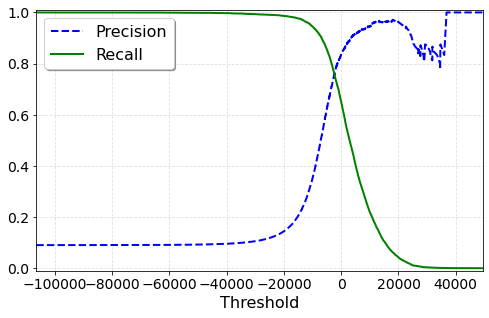

In [34]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

<div class="alert alert-block alert-info">
    <b>因为随着阈值增加，precision 有时会减少（虽然通常都会上升），所以 precision 的曲线有波动。</b>如上上图，如果将中间的箭头向右移动一个数字，precision 从 80%(4/5) 降为 75%(3/4)。<br><br>
    <b>而 recall 随着阈值增加只会降低。</b>
</div>

**<font color='crimson' size=2>方法 2: 画出 PR 曲线</font>**

In [35]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', lw=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True, alpha=0.4, ls='--')

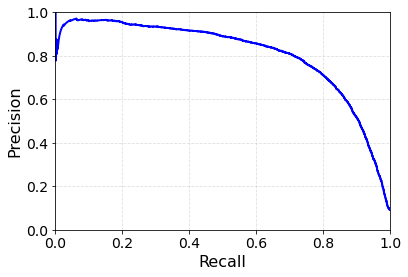

In [36]:
plot_precision_vs_recall(precisions, recalls)
plt.show()

可以看出，recall 大约在 0.8 处急剧下降（fall sharply），可能想在下降前作出选择，如，recall 在 0.6 的时候。但，**取决于项目**。

In [37]:
# 假设，想要 90% 的 precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

y_train_preds_90 = (y_scores >= threshold_90_precision)

print("阈值：", threshold_90_precision)
print("Precision:", precision_score(y_train_5, y_train_preds_90))
print("Recall:", recall_score(y_train_5, y_train_preds_90))

阈值： 3370.0194991439557
Precision: 0.9000345901072293
Recall: 0.4799852425751706


**通过调整阈值，可以获取任何 precision 的分类器。**

但是，precision 很高，但 recall 很低，这也是不行的。

**如果有人告诉你，分类器 precision 为 99% 的时候，要问问 TA recall 是多少。**

## 3.5 ROC 曲线（只二分类）

二分类另一种常用的工具是 **<font color='blue' size=2>ROC 曲线</font>**（Receiver operating characteristic）。

ROC 曲线绘制的是 TPR (recall) 和 FPR(=1-TNR)（负样本被误分为正样本的比例）。TNR 又称为 specificity，因此，ROC 曲线绘制的是 sensitivity 和 1-specificity 的关系。

$$TPR(Recall)=\frac{TP}{TP+FN}$$

$$FPR=\frac{FP}{FP+TN}$$

In [38]:
# 要绘制 ROC 曲线，先要各阈值下的计算 TPR 和 FPR
from sklearn.metrics import roc_curve
# 只适用于二分类

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [39]:
len(fpr), len(tpr), len(thresholds)

(3908, 3908, 3908)

In [40]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True, alpha=0.4, ls='--')

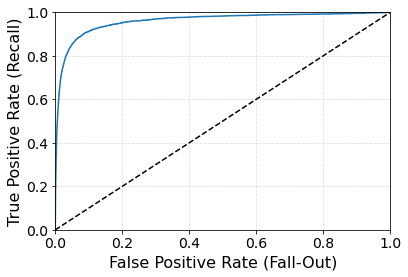

In [41]:
plot_roc_curve(fpr, tpr)
plt.show()

一种用于比较分类器的方法是计算 **<font color='blue' size=2>AUC 值（Area under the curve）</font>**。 完美分类器的 ROC AUC 值是 1，随机分类器的 ROC AUC 值是 0.5。

In [42]:
# 计算 AUC 值
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<div class="alert alert-block alert-info">
    <center><b>PR 曲线还是 ROC 曲线？</b></center><br>
    <b>经验法则是，当正类比较少（rare），或者更关注 FP 而不是 FN 时，选择 PR 曲线，否则选择 ROC 曲线。</b> 如，看这里 ROC 曲线和 AUC 值（0.96），可能会认为这个分类器非常不错。但是，这里的正类（数字5）非常少，从 PR 曲线可以看出，分类器有待改善。
</div>

In [43]:
# 看看 RF 的结果
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_rf = cross_val_predict(rf_clf, x_train, y_train_5, cv=3,
                                method='predict_proba')
y_probas_rf

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

**`RandomForestClassifier` 没有 `decision_function()` 方法，但有 `predict_proba()` 方法。 Scikit-Learn 的分类器通常含有其一，或者都有。**

**`predict_proba()`** 返回一个数组，每行表示一个样本，每列表示一个类别，表示该样本属于这些类别的概率。

**`roc_curve()` 需要 labels 和 scores，但这里没有 scores，可以直接使用正类的概率作为 scores。**

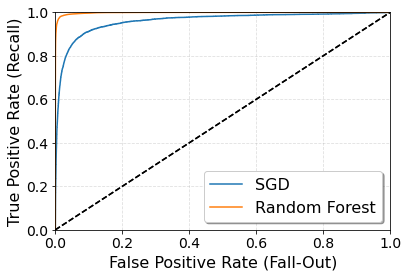

In [44]:
# 正类的概率作为 scores
y_scores_rf = y_probas_rf[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, y_scores_rf)

plot_roc_curve(fpr, tpr, label='SGD')
plot_roc_curve(fpr_rf, tpr_rf, label='Random Forest')
plt.legend(shadow=True, fontsize=16)
plt.show()

RF 的 ROC 曲线看起来比 SGD 的好：更接近左上角。

In [45]:
roc_auc_score(y_train_5, y_scores_rf)

0.9983436731328145

In [46]:
y_train_preds_rf = cross_val_predict(rf_clf, x_train, y_train_5, cv=3)

print("RF precison:", precision_score(y_train_5, y_train_preds_rf))
print("RF recall:", recall_score(y_train_5, y_train_preds_rf))
print("RF F1:", f1_score(y_train_5, y_train_preds_rf))

RF precison: 0.9905083315756169
RF recall: 0.8662608374838591
RF F1: 0.9242275142688446


# 4 多类分类（Multiclass Classification）

multiclass classfiers（又称为 multinomial classfiers）可以区分 2 以上的类别。

- 一些分类算法（如，LR、RF、朴素贝叶斯）可以直接处理多个类别


- 一些分类算法（如，SGD、SVM）是严格的二分类器，只能处理 2 个类别。

**对于 N 个类别的分类器，方法有：**

- **训练 N 个二分类器，每个类别建立一个（是/否）。** 在预测的时候，获取每个分类器的分数，哪个分类的分数高，就是哪个类别。这种称为 **<font color='blue' size=2>OvR (one-versus-the-rest, OvR)</font>**，或者 **<font color='blue' size=2>one-versus-all</font>**。


- **为每一对类别训练一个二分类器**（这里，一个用于区分 0 和 1，一个用于区分 0 和 2...一个用于区分 0 和 9...一个用于区分 1 和 2...），这称为 **<font color='blue' size=2>one-versus-one (OvO)</font>**。 **如果有 N 个类别，则需要训练 Nx(N-1)/2 个二分类器。** 预测时，看哪个类别获胜最多。 <font color='crimson'>OvO 的主要优点在于，每个二分类器只要对应的部分训练集就可以训练了。</font>

<font color='crimson'>一些算法（如 SVM）scale poorly with the size of 训练集。对于这些算法，OvO 是优先选择的（preferred），因为在小训练集上训练多个分类器比在大训练集上训练少数要更快。但对大多数二分类算法来说，OvR 是更好的选择（preferred）。</font>

**在使用二分类算法来进行多类分类（multiclass classification）时，Scikit-Learn 是能检测到的，这时，Scikit-Learn 会根据情况自动运行 OvR 或 OvO。**

In [47]:
# SVM 进行多类分类
# 使用的是 OvO 策略——训练了 45 个二分类器
from sklearn.svm import SVC

svc = SVC(gamma='auto', random_state=42)
svc.fit(x_train[:1000], y_train[:1000])  # 不然太慢了

SVC(gamma='auto', random_state=42)

如果调用 `decision_function()` 方法，对于每个样本会输出 10 个 score（而不是 1 个）——每个类别 1 个 score（it’s the number of won duels plus or minus a small tweak to break ties, based on the binary classifier scores）。

In [48]:
some_digit_scores = svc.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [49]:
# 最高分（索引 5）确实对应类别 5
np.argmax(some_digit_scores)

5

In [50]:
# The classes labels
svc.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

<div class="alert alert-block alert-info">
    <b>分类器训练好了，目标列（target class）的列表存在 <code>classes_</code> 属性（attribute）中，按值的大小排序。</b> 这里，<code>classes_</code> 中每个类别的 index 恰好是类别值，这么巧的时候很少发生。
</div>

可以使用 **`OneVsOneClassifier`** 或者 **`OneVsRestClassifier`** 来强制 Scikit-Learn 使用 OvO 或者 OvR。

In [51]:
# 强制使用 OvR 策略
from sklearn.multiclass import OneVsRestClassifier

svc_ovr = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
svc_ovr.fit(x_train[:1000], y_train[:1000])
svc_ovr.predict([some_digit])

array([5], dtype=uint8)

In [52]:
len(svc_ovr.estimators_)

10

In [53]:
# 使用 SGD 分类器
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

这一次，Scikit-Learn 在内部使用 OvR 策略——因为这里有 10 个类别，所以训练 10 个二分类器。 在样本上调用 `decision_function()` 时为每个类别输出一个值。

In [54]:
# 每个类别的 score
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

分类器对这次的预测结果非常有信心——除了类别 3 的 score 为正数，其余的 score 都是负数。但是翻车了，预测错误。

使用交叉验证来评估分类器：

In [55]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

如果是一个随机分类器（random classifier）的话，准确率大概是 10%。所以，这个结果还行，但还有提升的空间： scale 特征。

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

# 5 误差分析（Error Analysis）

<font color='crimson'>可以分析模型犯的错误类型（the types of errors）来提升模型性能。</font>

In [57]:
# 查看混淆矩阵
y_train_preds = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_preds)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

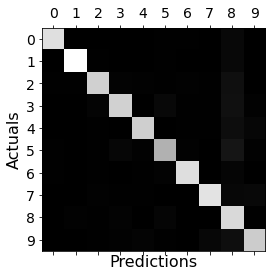

In [58]:
# 数字太多了，用图片表示（image representation）
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xticks(range(10))
plt.xlabel("Predictions", fontsize=16)
plt.yticks(range(10))
plt.ylabel("Actuals", fontsize=16)
plt.show()

> 可以使用 **`sklearn.metrics.plot_confusion_matrix`**。

看起来不错，大多数都在主对角线上，说明分类正确。

类别 5 看起来有点暗，这可能意味着数据集中类别 5 图片比较少或者分类器在类别 5 图片上的效果较差（事实这 2 种情况都存在）。

**关注错误。** 应该看比例，而不是看数量（对样本较多的类别不公平）。

In [59]:
# 关注错误
row_sums = conf_mx.sum(axis=1, keepdims=True)  # shape: (10, 1)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.41583657e-01, 0.00000000e+00, 3.71433395e-03, 8.44166807e-04,
        1.35066689e-03, 7.25983454e-03, 6.07800101e-03, 1.01300017e-03,
        3.79875063e-02, 1.68833361e-04],
       [0.00000000e+00, 9.49273213e-01, 5.48798576e-03, 3.55977455e-03,
        5.93295758e-04, 6.52625334e-03, 5.93295758e-04, 1.03826758e-03,
        3.14446752e-02, 1.48323939e-03],
       [4.53172205e-03, 4.53172205e-03, 8.76132931e-01, 1.54414233e-02,
        1.22524337e-02, 4.53172205e-03, 1.12453844e-02, 6.04229607e-03,
        6.34441088e-02, 1.84625713e-03],
       [3.58832164e-03, 2.77279400e-03, 1.90833469e-02, 8.52552602e-01,
        3.26211059e-04, 3.31104224e-02, 4.40384929e-03, 6.52422117e-03,
        6.57315283e-02, 1.19067036e-02],
       [2.05409106e-03, 2.39643958e-03, 7.01814447e-03, 1.54056830e-03,
        8.87024991e-01, 2.05409106e-03, 5.81992468e-03, 4.62170490e-03,
        5.93974666e-02, 2.80725779e-02],
       [4.98063088e-03, 2.76701716e-03, 5.53403431e-03, 3.09905921e-02,
   

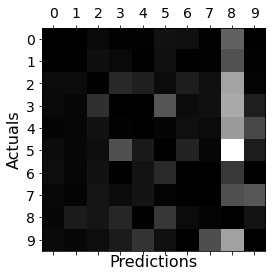

In [60]:
# 用 0 填充对角线
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.xticks(range(10))
plt.xlabel("Predictions", fontsize=16)
plt.yticks(range(10))
plt.ylabel("Actuals", fontsize=16)
plt.show()

现在可以看到分类器犯的错误类型了。第 8 列看起来比较亮，这说明很多图片被误分为类别 8 了。然后，第 8 行看起来并不差，这说明类别 8 的图片基本分类正确。

混淆矩阵并不是完成对称的（necessarily symmetrical）。类别 3 和类别 5 经常弄混。

**分析混淆矩阵通常可以帮助理解如何提升分类器的性能。** 在这里，需要将精力放在误分为类别 8 的错误上。

- 如，收集更多看起来像 8 的图片，有助于分类器将其与真实的 8 区分开。


- 或者，开发新的特征（engineer new features）用于训练分类器，如，计算闭环（closed loops）的算法（8 有 2 个圈圈，5 只有 1 个圈圈）。


- 或者，使用 Scikit-Image、Pillow、OpenCV 预处理图片，让某些模式（如圈圈之类的）更加突出。

分析单个的错误也可以获取 insights———分类器在做什么、分类器为什么失败，但这样比较费时（time-consuming）。

In [61]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis('off')

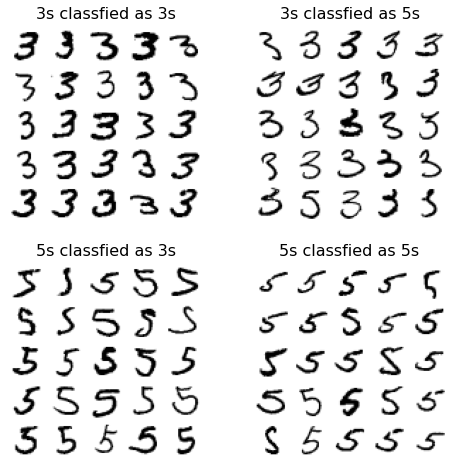

In [62]:
# 比较 3 和 5
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_preds == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_preds == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_preds == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_preds == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221).set_title("3s classfied as 3s", fontsize=16)
plot_digits(x_aa[:25], images_per_row=5)

plt.subplot(222).set_title("3s classfied as 5s", fontsize=16)
plot_digits(x_ab[:25], images_per_row=5)

plt.subplot(223).set_title("5s classfied as 3s", fontsize=16)
plot_digits(x_ba[:25], images_per_row=5)

plt.subplot(224).set_title("5s classfied as 5s", fontsize=16)
plot_digits(x_bb[:25], images_per_row=5)
plt.show()

确实有很多奇怪的图片难以区分，即使人也不分出来。但是大部多数错误还是很明显的。这是因为，使用的简单 `SGDClassifier` 是一个线性模型——为每个像素（pixel）分配一个权重，每个像素的加权和作为类别的 score。而数字 3 和数字 5 非常相似，仅是部分不同。要想减少 3 和 5 的错误，其中一个方法是进行预处理。

# 6 多标签分类（Multilabel Classification）

有些情况下，需要分类器为每个样本输出多个类别。

如人脸识别分类器（face-recognition）：为图片中每个人脸添加一个标签。假如训练后，可以识别出 3 张脸——张三、李四、王二麻。然后，预测一张仅有张三和王二麻的图片时，输出 `[1, 0, 1]`。这种，**<font color='blue' size=2>输出多个二元标签（multilabel binary tags）的分类器称为多标签（multilabel）分类器</font>**。

In [63]:
# 构建多标签 y
y_train_large = (y_train >= 7)  # 是否大于 5
y_train_odd = (y_train % 2 == 1)  # 是否为奇数
y_multilabel = np.c_[y_train_large, y_train_odd]

y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [64]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [65]:
knn_clf.predict([some_digit])

array([[False,  True]])

**评价 multilabel classifier 的方法有很多，选择哪一个取决于项目。**

其中一个方法是计算每个标签的 F1 分数（或者之前二元分类器中的度量方法），然后简单地计算平均值。

In [66]:
# Just for illustation
y_train_knn_preds = knn_clf.predict(x_train[:10])
f1_score(y_multilabel[:10], y_train_knn_preds[:10], average='macro')

1.0

这里是假设所有标签同等重要，但实际可能不是这样的。尤其是图片中王二麻比张三李四多得多的时候，可以想给王二麻更高的权重。简单的方法是为每个标签设置一个等于其自身样本数量的权重，`average='weight'` 即可。

# 7 多输出分类（Multioutput Classification）

全称为 **<font color='blue' size=2>multioutput-multiclass classification</font>**，简称为 **<font color='blue' size=2>multioutput classification</font>**。输出多个标签（label），每个标签有多个类别（class）。

如，给图片去噪。接收一张有噪声的图片，输出一个干净的图片——以像素强度（pixel intensities）作为呈现方式。这里，分类器的输出是多个标签（一个像素一个标签），每个标签可能有多个值（像素强度从 0 到 255）。

In [75]:
# 构建数据集
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

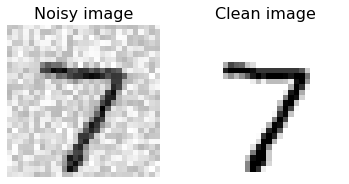

In [92]:
some_index = 0
plt.subplot(121).set_title("Noisy image", fontsize=16)
plot_digits(x_test_mod[[some_index]])
plt.subplot(122).set_title("Clean image", fontsize=16)
plot_digits(y_test_mod[[some_index]])
plt.show()

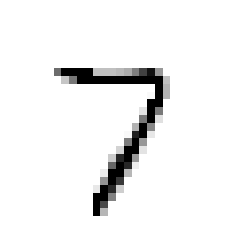

In [96]:
knn_clf.fit(x_train_mod, y_train_mod)

# Predict
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digits(clean_digit)